In [ ]:
!pip install -q kagglehub
import os
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
def download_dataset():
    """Download UTKFace dataset using kagglehub"""
    import kagglehub
    path = kagglehub.dataset_download("jangedoo/utkface-new")
    print(f"Dataset downloaded to: {path}")

    # Find the actual image directory
    for root, dirs, files in os.walk(path):
        if "UTKFace" in dirs:
            return os.path.join(root, "UTKFace")
    return path

# Download dataset
dataset_path = download_dataset()

Dataset downloaded to: /root/.cache/kagglehub/datasets/jangedoo/utkface-new/versions/1


In [ ]:
def load_data(dataset_path, img_size=(128, 128), test_size=0.2, max_samples=None):
    """Load and preprocess images with age categorization"""
    age_bins = [(0, 11), (12, 23), (24, 35), (36, 47), (48, 59), (60, 100)]
    X, y = [], []

    for filename in os.listdir(dataset_path):
        if max_samples and len(X) >= max_samples:
            break

        if filename.endswith(('.jpg', '.chip.jpg')):
            try:
                # Parse age from filename (format: age_gender_race_date.jpg)
                age = int(filename.split('_')[0])

                # Categorize age
                for idx, (low, high) in enumerate(age_bins):
                    if low <= age <= high:
                        # Load and preprocess image
                        img_path = os.path.join(dataset_path, filename)
                        img = cv2.imread(img_path)
                        if img is not None:
                            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                            img = cv2.resize(img, img_size)
                            img = img.astype(np.float32) / 255.0

                            X.append(img)
                            y.append(idx)
                        break
            except:
                continue

    # Convert to numpy arrays
    X = np.array(X)
    y = tf.keras.utils.to_categorical(y, num_classes=len(age_bins))

    return train_test_split(X, y, test_size=test_size, random_state=42)

# Load data (using 5000 samples for quick testing - remove max_samples for full dataset)
X_train, X_test, y_train, y_test = load_data(dataset_path, max_samples=5000)
print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

Training samples: 4000, Test samples: 1000


In [ ]:
def create_model(input_shape, num_classes):
    """Build CNN model from scratch"""
    model = tf.keras.Sequential([
        # Feature extraction
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2)),

        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2)),

        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2)),

        # Classification head
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    return model

# Create model
model = create_model(X_train.shape[1:], y_train.shape[1])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,518,470 (24.87 MB)

 Trainable params: 6,518,022 (24.86 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.3405 - loss: 4.8115 - val_accuracy: 0.1140 - val_loss: 11.4057 - learning_rate: 0.0010
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.4658 - loss: 1.4892 - val_accuracy: 0.3230 - val_loss: 3.4708 - learning_rate: 0.0010
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.4771 - loss: 1.3639 - val_accuracy: 0.4800 - val_loss: 1.3077 - learning_rate: 0.0010
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5158 - loss: 1.2837 - val_accuracy: 0.4780 - val_loss: 1.3931 - learning_rate: 0.0010
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5025 - loss: 1.2723 - val_accuracy: 0.5060 - val_loss: 1.2767 - learning_rate: 0.0010
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5362 - loss: 1.1829 - val_accuracy: 0.5480 - val_loss: 1.1405 - learning_rate: 0.0010
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5305 - loss: 

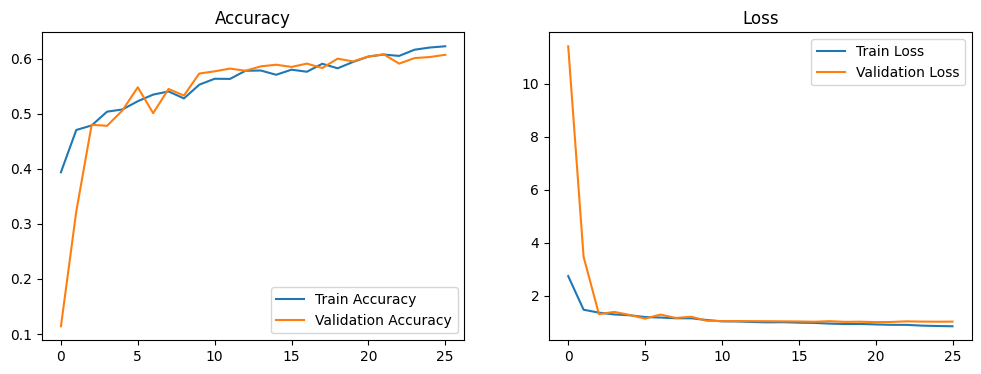

In [ ]:
# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3)
]

# Train model
history = model.fit(X_train, y_train,
                   epochs=30,
                   batch_size=32,
                   validation_data=(X_test, y_test),
                   callbacks=callbacks)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [ ]:
# Add these right after model creation (before training)
model = create_model(X_train.shape[1:], y_train.shape[1])

# Enhanced optimizer configuration
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0001,  # Lower initial learning rate
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
)
model.compile(optimizer=optimizer,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

# Enhanced callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.h5',
        save_best_only=True,
        monitor='val_accuracy'
    )
]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Add class weights to handle imbalance
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                classes=np.unique(y_true),
                                                y=y_true)
class_weights = dict(enumerate(class_weights))

# Retrain with weights
history = model.fit(X_train, y_train,
                   validation_data=(X_test, y_test),
                   class_weight=class_weights,
                   epochs=20,
                   batch_size=32)

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.2798 - loss: 2.6309 - val_accuracy: 0.1180 - val_loss: 2.5961
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.4052 - loss: 1.3280 - val_accuracy: 0.2830 - val_loss: 1.7885
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.4958 - loss: 1.1201 - val_accuracy: 0.3390 - val_loss: 1.7547
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5328 - loss: 1.0060 - val_accuracy: 0.4930 - val_loss: 1.2751
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5932 - loss: 0.9064 - val_accuracy: 0.5220 - val_loss: 1.1630
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6357 - loss: 0.8138 - val_accuracy: 0.4970 - val_loss: 1.1790
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6809 - loss: 0.6991 - val_accuracy: 0.5060 - val_loss: 1.1920
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7332 - loss: 0.5890 - val_acc

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5385 - loss: 1.3625

Test Accuracy: 0.5500
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

Classification Report:
              precision    recall  f1-score   support

        0-11       0.88      0.83      0.86       155
       12-23       0.39      0.38      0.39       108
       24-35       0.62      0.69      0.65       371
       36-47       0.29      0.17      0.22       158
       48-59       0.29      0.51      0.37        98
      60-100       0.68      0.43      0.53       110

    accuracy                           0.55      1000
   macro avg       0.53      0.50      0.50      1000
weighted avg       0.56      0.55      0.54      1000



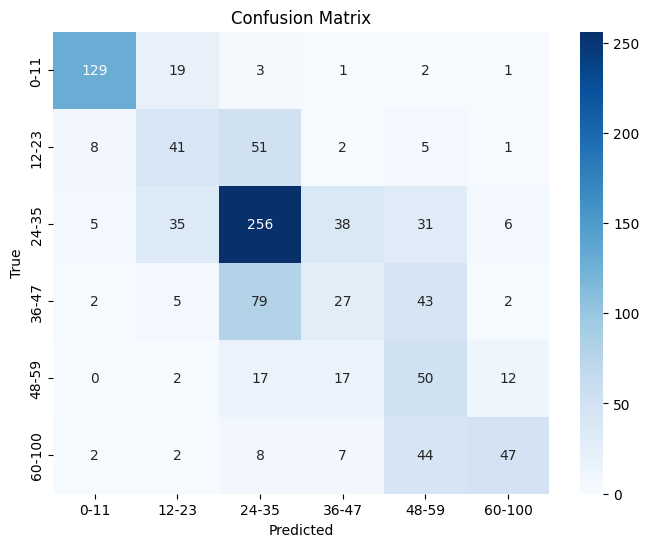

In [ ]:
# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_acc:.4f}")

# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
age_ranges = ["0-11", "12-23", "24-35", "36-47", "48-59", "60-100"]
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=age_ranges))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=age_ranges, yticklabels=age_ranges)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Save the trained model
model.save('utkface_age_classifier.h5')
print("Model saved successfully!")

# To load later:
# model = tf.keras.models.load_model('utkface_age_classifier.h5')

Model saved successfully!


Saving 53.jpg to 53 (2).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


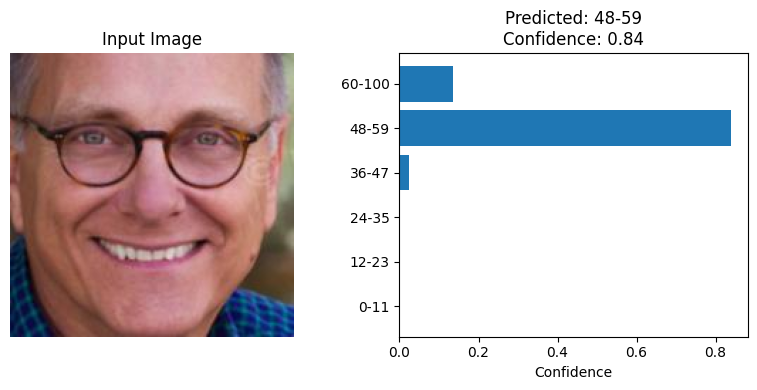


Final Prediction: 48-59


In [ ]:
def predict_age(image_path, model, age_ranges):
    """Predict age category for a custom image"""
    # Load and preprocess image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image from {image_path}")
        return

    # Convert and resize
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))  # Must match training size
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Make prediction
    pred = model.predict(img)
    predicted_class = np.argmax(pred)
    confidence = np.max(pred)
    age_range = age_ranges[predicted_class]

    # Display results
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Input Image")

    plt.subplot(1, 2, 2)
    plt.barh(age_ranges, pred[0])
    plt.xlabel("Confidence")
    plt.title(f"Predicted: {age_range}\nConfidence: {confidence:.2f}")
    plt.tight_layout()
    plt.show()

    return age_range

# Example usage:
from google.colab import files

# Upload your image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# Define age ranges (must match training)
age_ranges = ["0-11", "12-23", "24-35", "36-47", "48-59", "60-100"]

# Make prediction
predicted_age = predict_age(image_path, model, age_ranges)
print(f"\nFinal Prediction: {predicted_age}")

In [ ]:
# Save the trained model
model.save("utkface_age_classifiermain.h5")
print("✅ Model saved as utkface_age_model.h5")


✅ Model saved as utkface_age_model.h5


In [ ]:
from google.colab import files

# Download model file
files.download("utkface_age_classifiermain.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("utkface_age_classifiermain.h5")
print("✅ Model loaded successfully!")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


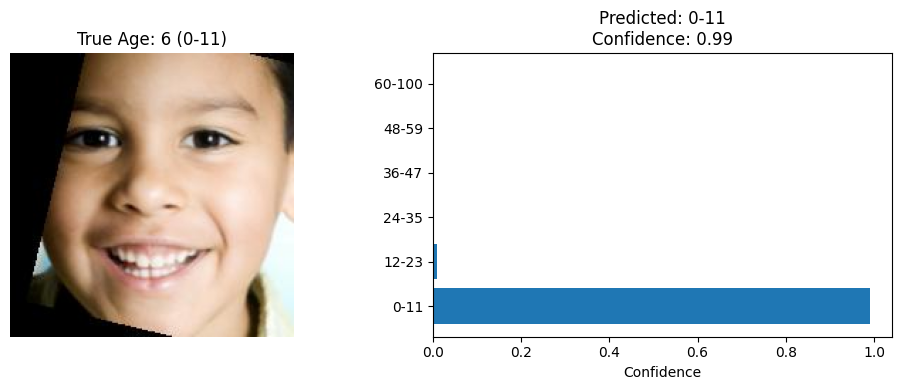


Filename: 6_0_0_20170110215629811.jpg.chip.jpg
True Age: 6 | True Category: 0-11
Predicted: 0-11 | Confidence: 0.99


In [ ]:
import random

def predict_random_image(dataset_path, model, age_ranges):
    """Select a random image from dataset and predict its age"""
    # Get list of all image files
    image_files = [f for f in os.listdir(dataset_path)
                  if f.endswith(('.jpg', '.chip.jpg'))]

    if not image_files:
        print("No images found in dataset directory")
        return

    # Randomly select an image
    random_image = random.choice(image_files)
    image_path = os.path.join(dataset_path, random_image)

    # Extract true age from filename
    true_age = int(random_image.split('_')[0])
    true_category = None
    for idx, (low, high) in enumerate([(0,11),(12,23),(24,35),(36,47),(48,59),(60,100)]):
        if low <= true_age <= high:
            true_category = age_ranges[idx]
            break

    # Make prediction
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)

    pred = model.predict(img)
    predicted_class = np.argmax(pred)
    confidence = np.max(pred)
    age_range = age_ranges[predicted_class]

    # Display results
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.title(f"True Age: {true_age} ({true_category})")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.barh(age_ranges, pred[0])
    plt.xlabel("Confidence")
    plt.title(f"Predicted: {age_range}\nConfidence: {confidence:.2f}")
    plt.tight_layout()
    plt.show()

    print(f"\nFilename: {random_image}")
    print(f"True Age: {true_age} | True Category: {true_category}")
    print(f"Predicted: {age_range} | Confidence: {confidence:.2f}")

# Example usage:
age_ranges = ["0-11", "12-23", "24-35", "36-47", "48-59", "60-100"]
predict_random_image(dataset_path, model, age_ranges)